<a href="https://colab.research.google.com/github/Vantage-AI/blog_rotations/blob/master/unsupervised_learning_image_rotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised representation learning
This notebook shows how one can do unsupervised representation learning, similar to [this paper](https://arxiv.org/pdf/1803.07728.pdf). 

We train a model on the [fashion mnist dataset](https://github.com/zalandoresearch/fashion-mnist). The model we use is described [here](https://github.com/zalandoresearch/fashion-mnist/blob/master/benchmark/convnet.py). 

## Initialize

In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools

from tensorflow.keras.datasets import cifar10
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# tf.enable_eager_execution()
print(f"Tensorflow version: {tf.__version__}; GPU available: {tf.test.is_gpu_available()}") # default version of tensorflow is still 1.15, will change to 2.x soon
%matplotlib inline

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Tensorflow version: 2.2.0; GPU available: True


In [2]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [0]:
BATCH_SIZE = 1024
PATIENCE = 5

## Useful functions

In [0]:
def evaluate_performance(model, features, labels):
    probas = model.predict(features)
    print(probas.shape)
    preds = probas.argmax(axis=1)
    print(classification_report(labels, preds))

In [0]:
def rot90(x, y):
  return tf.image.rot90(x, k=y), y

def create_unsupervised_dataset(features):
  """Create a tensorflow dataset where the labels are rotations."""
  N = len(features)
  labels = np.random.choice(range(4), size=N).astype(np.int32)
  features_dataset = tf.data.Dataset.from_tensor_slices(features) 
  labels_dataset = tf.data.Dataset.from_tensor_slices(labels) 
  dataset = tf.data.Dataset.zip((features_dataset, labels_dataset)) 
  dataset = dataset.map(rot90)
  dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
  return dataset

def create_supervised_dataset(features, labels):
  """Create a dataset with regular labels."""
  features_dataset = tf.data.Dataset.from_tensor_slices(features) 
  labels_dataset = tf.data.Dataset.from_tensor_slices(labels) 
  dataset = tf.data.Dataset.zip((features_dataset, labels_dataset)) 
  dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
  return dataset

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Get dataset
We download the dataset and preprocess it.

In [0]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)
labelmap = {0:"T-shirt/top",
1:	"Trouser",
2:	"Pullover",
3:	"Dress",
4:	"Coat",
5:	"Sandal",
6:	"Shirt",
7:	"Sneaker",
8:	"Bag",
9: "Ankle boot"}

# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# labelmap = {0:"airplane",
# 1:"automobile",				
# 2:'bird',							
# 3:'cat',									
# 4:'deer',										
# 5:'dog',									
# 6:'frog',										
# 7:"horse",										
# 8:"ship",									
# 9:"truck"}

In [0]:
X = X.reshape((-1, 28, 28, 1))
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

In [0]:
# NOrmalize pixel values to be in the range [0, 1].
X_train = (X_train / 255.).astype(np.float32)
X_test = (X_test / 255.).astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [0]:
# Leave out 1000 images as the "labelled" set.
X_labelled = X_train[:1000] # leave these 1000 out, we will assume this is the set of labeled images
y_labelled = y_train[:1000]

# Use the other images without their labels
X_train, X_val = X_train[1000:50000], X_train[50000:60000]
y_train, y_val  = y_train[1000:50000], y_train[50000:60000]


train_dataset = create_unsupervised_dataset(X_train)
val_dataset = create_unsupervised_dataset(X_val)
test_dataset = create_unsupervised_dataset(X_test)

val_dataset_labelled = create_supervised_dataset(X_val, y_val)
test_dataset_labelled = create_supervised_dataset(X_test, y_test)

Label: 180 deg counterclockwise


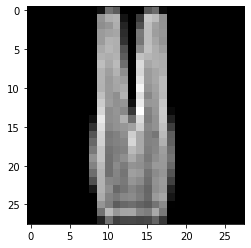

In [10]:
for x, label in train_dataset:
  break
ind = 0
d_rot = {0:0, 1:90, 2:180, 3:270}
print(f"Label: {d_rot[label[ind].numpy()]} deg counterclockwise")
plt.imshow(np.squeeze(x[ind].numpy()), cmap='gray');

## Model 1: Rotation predictor
This model attempts to predict if the picture has been rotated by 0, 90, 180 or 270 degrees.

In [0]:
model_1 = tf.keras.Sequential([tf.keras.layers.Input(shape=(28, 28, 1)),
                               tf.keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding='same', name='conv1'),
                               tf.keras.layers.MaxPool2D((2, 2)),
                               tf.keras.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, padding='same', name='conv2'),
                               tf.keras.layers.GlobalAveragePooling2D(),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dropout(0.2, name='dropout'),
                               tf.keras.layers.Dense(units=16, activation=tf.nn.relu, name='dense'), 
                               tf.keras.layers.Dense(units=4, activation='softmax', name='output')])

In [0]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['sparse_categorical_accuracy']
                          )

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        51264     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1

In [0]:

model_1.fit(train_dataset,
      epochs=int(1e2),
      validation_data=val_dataset, 
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)], 
      verbose=1)

Epoch 1/100
48/48 [==============================] - 5s 106ms/step - loss: 1.2499 - sparse_categorical_accuracy: 0.3710 - val_loss: 0.9691 - val_sparse_categorical_accuracy: 0.5354
Epoch 2/100
48/48 [==============================] - 5s 97ms/step - loss: 0.8246 - sparse_categorical_accuracy: 0.6717 - val_loss: 0.5079 - val_sparse_categorical_accuracy: 0.8280
Epoch 3/100
48/48 [==============================] - 5s 103ms/step - loss: 0.4977 - sparse_categorical_accuracy: 0.8279 - val_loss: 0.3731 - val_sparse_categorical_accuracy: 0.8839
Epoch 4/100
48/48 [==============================] - 5s 100ms/step - loss: 0.3944 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.3014 - val_sparse_categorical_accuracy: 0.9077
Epoch 5/100
48/48 [==============================] - 5s 104ms/step - loss: 0.3245 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.9283
Epoch 6/100
48/48 [==============================] - 5s 102ms/step - loss: 0.2721 - sparse_categ

## Feature_extractor
We use all but the last of the layers as a feature extractor. The output feature vector consists of 1024 numbers.

In [0]:
feature_extractor = tf.keras.models.Sequential(name='feature_extractor')
feature_extractor.add(tf.keras.layers.Input(shape=(28, 28, 1)))
for layer in model_1.layers[:-1]:
  feature_extractor.add(layer)

# Fix layers
for ix, _ in enumerate(feature_extractor.layers):
  feature_extractor.layers[ix].trainable = False
print(f"All layers frozen? {np.array([not layer.trainable for layer in feature_extractor.layers]).all()}\n")

We can extract the feature vectors

In [0]:
# feature_vectors_train = feature_extractor.predict(train_dataset_labelled)

for ix, (feature, label) in enumerate(test_dataset_labelled):
  feature_vectors_batch = feature_extractor.predict(feature)
  if ix == 0:
    feature_vectors_test = feature_vectors_batch 
    y_true = label
  else:
    feature_vectors_test = np.concatenate((feature_vectors_test, feature_vectors_batch ))
    y_true = np.concatenate((y_true, label))

#### TSNE
Using TSNE we can visualize the embeddings in 2D. As we can see the model just trained on rotations created embeddings that can already distinguish between trousers, shirts and dresses, and footwear. In other words, it has learned a semantic feature representation.

In [0]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate=1000, n_iter=250, verbose=1)
results_embedded_test = tsne.fit_transform(feature_vectors_test)

In [0]:
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

for l in np.unique(y_true):
    mask = (y_true.flatten() == l)
    plt.scatter(results_embedded_test[mask,0], results_embedded_test[mask,1], cmap=cmap, label = labelmap[l])
plt.xlim(-10, 6)
plt.legend(loc=3)

# Model 2: classifier
This model is a regular classifier for the 10 classes of the fashion mnist dataset. We use the feature extractor, trained only on rotations, and add a new top layer with softmax activation and 10 nodes. Only the top layer is trainable.

In [0]:
# N_tot = X_train_supervised.shape[0]
# N = min(N_tot, 100)
N = 1000
train_dataset_labelled = create_supervised_dataset(X_labelled[:N], y_labelled[:N]) # We train on only 100 images
weights = compute_class_weight(class_weight='balanced', classes = np.arange(10), y = y_labelled[:N])

In [0]:
model_2 = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(28, 28, 1)), 
                                      feature_extractor, # We do not add dropout after this layers since the parameters are anyway frozen.
                                      # tf.keras.layers.Dropout(0.2, name='dropout'),
                                      tf.keras.layers.Dense(units=10, activation='softmax', name='output')])

model_scratch = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(28, 28, 1)), 
                                            tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same', name='conv1'),
                                            tf.keras.layers.MaxPool2D((2, 2)),
                                            tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same', name='conv2'),
                                            tf.keras.layers.GlobalAveragePooling2D(),
                                            tf.keras.layers.Flatten(),
                                            tf.keras.layers.Dropout(0.2, name='dropout'),
                                            tf.keras.layers.Dense(units=16, activation=tf.nn.relu, name='dense'),
                                            tf.keras.layers.Dense(units=10, activation='softmax', name='output')])

# model_scratch = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(32, 32, 3)), 
#                                             tf.keras.layers.Conv2D(16, (5, 5), activation=tf.nn.relu, padding='same', name='conv1'),
#                                             tf.keras.layers.MaxPool2D((2, 2)),
#                                             tf.keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding='same', name='conv2'),
#                                             tf.keras.layers.MaxPool2D((2, 2)),
#                                             tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same', name='conv3'),
#                                             tf.keras.layers.MaxPool2D((2, 2)),
#                                             tf.keras.layers.Flatten(),
#                                             tf.keras.layers.Dense(units=128, activation=tf.nn.relu, name='dense1'),
#                                             tf.keras.layers.Dropout(0.2),
#                                             tf.keras.layers.Dense(units=10, activation='softmax', name='output')])

In [0]:
for layer in model_2.layers:
 if layer.name == 'feature_extractor':
   layer.trainable=False

for layer in model_2.layers:
  print(f"{layer.name} trainable? {layer.trainable}")

In [0]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['sparse_categorical_accuracy'],
                          )

In [0]:
model_2.fit(train_dataset_labelled,
      epochs=int(1e4),
      validation_data=val_dataset_labelled, 
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
      # class_weight=weights,
      verbose=1)

In [0]:
model_2.evaluate(test_dataset_labelled)

for ix, (feature, label) in enumerate(test_dataset_labelled):
  pred = model_2.predict(feature).argmax(axis=1)
  if ix == 0:
    y_pred = pred
    y_true = label
  else:
    y_pred = np.concatenate((y_pred, pred))
    y_true = np.concatenate((y_true, label))

plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes = labelmap.values())

In [0]:
model_scratch.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['sparse_categorical_accuracy']
                          )

model_scratch.fit(train_dataset_labelled,
      epochs=int(1e4),
      validation_data=val_dataset_labelled, 
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
      verbose=1)

model_scratch.evaluate(test_dataset_labelled)

for ix, (feature, label) in enumerate(test_dataset_labelled):
  pred = model_scratch.predict(feature).argmax(axis=1)
  if ix == 0:
    y_pred = pred
    y_true = label
  else:
    y_pred = np.concatenate((y_pred, pred))
    y_true = np.concatenate((y_true, label))
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes = labelmap.values())

In [0]:
for ix, (feature, label) in enumerate(train_dataset_labelled):
  pred = model_scratch.predict(feature).argmax(axis=1)
  if ix == 0:
    y_pred = pred
    y_true = label
  else:
    y_pred = np.concatenate((y_pred, pred))
    y_true = np.concatenate((y_true, label))

plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes = labelmap.values())

### Fine tune
We can also fine tune this model further by opening all layers for training (this gives similar performance to just training the full model from scratch).

In [0]:
for ix in range(len(model_2.layers)):
  model_2.layers[ix].trainable = True
print(f"All layers open for training? {np.array([layer.trainable for layer in model_2.layers]).all()}\n")
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['sparse_categorical_accuracy']
                          )



model_2.fit(train_dataset_labelled,
      epochs=int(1e4),
      validation_data=val_dataset_labelled, 
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
      verbose=1)

In [0]:
model_2.evaluate(test_dataset_labelled)

for ix, (feature, label) in enumerate(test_dataset_labelled):
  pred = model_2.predict(feature).argmax(axis=1)
  if ix == 0:
    y_pred = pred
    y_true = label
  else:
    y_pred = np.concatenate((y_pred, pred))
    y_true = np.concatenate((y_true, label))

plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes = labelmap.values())